In [1]:
%load_ext autoreload
%autoreload 2

import os 
import warnings

import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

os.chdir("../../") # cell can only be run once!
plt.style.use("src/matplotlib.rc")
warnings.filterwarnings('ignore') 

## Definitions and data loading

To begin, let's load data on a ternary phase diagram system of FeCoNi [1,2]. 

[1] Yoo, Young-kook et al. “Identification of amorphous phases in the Fe–Ni–Co ternary alloy system using continuous phase diagram material chips.” Intermetallics 14 (2006): 241-247.

[2] Alex Wang, Haotong Liang, Austin McDannald, Ichiro Takeuchi, Aaron Gilad Kusne, Benchmarking active learning strategies for materials optimization and discovery, Oxford Open Materials Science, Volume 2, Issue 1, 2022, itac006, https://doi.org/10.1093/oxfmat/itac006.

In [ ]:
!wget https://github.com/usnistgov/remi/raw/nist-pages/data/Combinatorial%20Libraries/Fe-Co-Ni/FeCoNi_benchmark_dataset_220501a.mat
!mkdir datasets
!mv FeCoNi_benchmark_dataset_220501a.mat datasets/

This dataset consists of a series of alloys in the Fe-Co-Ni system in which the fraction (composition) of each element can be varied. For each alloy, two magnetic properties are measured: coercivity and Kerr Rotation.

Formally, the $X$ space (design space) consists of compositions $C_1, C_2$, where $C_3 = C_1 + C_2$; $x$ is a single alloy. $Y$ is the corresponding measured property space; here $y = (y_1, y_2)$ is a single tuple of measured properties.

In [3]:
from src.utils import load_ternary_data

X, Y = load_ternary_data('datasets/FeCoNi_benchmark_dataset_220501a.mat')

n_features, n_properties = X.shape[1], Y.shape[1]

print("Size of the design space: {}, Size of the measured property space: {}".format(X.shape, Y.shape))

Size of the design space: (921, 2), Size of the measured property space: (921, 2)


We normalize X to between 0-1 for each of the compositions. We normalize Y to be between -1 and 1 for each of the properties. Note, here there is a question of how Y can be normalized when it is unknown (i.e. we shouldn't know the minimum or maximum values). In practice, the max and min values are obtained based on a user guess and can be approximate. 

In [4]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

scalers = [x_scaler, y_scaler]

X_norm = x_scaler.fit_transform(X)
Y_norm = y_scaler.fit_transform(Y)

Each measurement $y$ corresponds to a noisy measurement of the true underlying property values as shown below. $f_*(x)$ is the true unknown ground truth function that we sample from when we perform measurements. In a sequential experiment setup, we choose an $x$ to measure and obtain the corresponding $y$. While we know the whole set of $X$, both $Y$ and $f_*(X)$ are unknown prior to experimentation.

\begin{align*}
  y = f_*(x) + \epsilon \quad \quad \quad ; \epsilon \ \mathcal{N}(0, \sigma^2)
\end{align*}

##### In this notebook, we assume no measurement noise and therefore $y = f_*(x)$.

## Converting an experimental goal into an algorithm

An experimental goal can be specified via an algorithmic "recipe". The idea is to write a procedure that would isolate the specific relevant portion of the design space *if the true underlying function were known*. In the framework here, we associate an *id* with each design point; i.e. *id* = 5 corresponds to $X_5$ and so on. Our goal is to determine the set of *ids* of interest. 

Let's consider the following simple experimental goal: find the entire set of design points for which the Kerr Rotation property ($Y_1$) falls between the values of 5.0 and 10.0. We could express this as follows:


In [5]:
def user_algorithm(f_x, x):

    a = 5.0 # lower threshold
    b = 10.0 # upper threshold

    f_1 = f_x[:,0] # only take the first property column

    ids1 = set(np.where(f_1 >= a)[0]) # the set of ids where f_1 is bigger/equal to a
    ids2 = set(np.where(f_1 <= b)[0]) # the set of ids where f_1 is smaller/equal to b

    ids_both = ids1.intersection(ids2) # the set of ids that match both conditions. i.e. a <= f_1 <= b

    return list(ids_both) # this is a list of ids corresponding to the target subset when the algorithm is executed on f_x

To use our framework, we add a few extra details. Our custom algorithm should be implemented as a python class and should inherit from the base class <code>SubsetAlgorithm</code>. Here, the user's responsibility is to implement the function <code>user_algorithm(self, f_x, x)</code>, a function that must return a list of target indices.

Note, parameters (e.g. specific thresholds, percentiles etc) can be passed to the algorithm via the user_algo_params dictionary. 

In [6]:
from src.algorithms import SubsetAlgorithm

class LevelBandAlgorithm(SubsetAlgorithm):
    def __init__(self, user_algo_params):
        super().__init__(user_algo_params)

    def user_algorithm(self, f_x, x):
        a = self.user_algo_params["a"]
        b = self.user_algo_params["b"]
        
        f_1 = f_x[:,0] # only take the first property column
        ids1 = set(np.where(f_1 >= a)[0]) # the set of ids where f_1 is bigger/equal to a
        
        ids2 = set(np.where(f_1 <= b)[0]) # the set of ids where f_1 is smaller/equal to b
        ids_both = ids1.intersection(ids2) # the set of ids that match both conditions. i.e. a <= f_1 <= b

        return list(ids_both)

In this example, we instantiate the class as follows. Here, we also pass <code>scalers</code> (a list of sklearn standardization objects described above) to the user_algo_params dictionary. This is the only REQUIRED set of parameters for the algorithm. 

In [7]:
algorithm = LevelBandAlgorithm(user_algo_params = {"scalers": scalers, "a": 5.0, "b": 10.0})

To "execute" an algorithm on the true NORMALIZED function and NORMALIZED design space, run:

<code>algorithm.identify_subspace(f_x = Y_norm, x = X_norm)</code>


In [8]:
true_target_ids = algorithm.identify_subspace(f_x = Y_norm, x = X_norm)

Looking at the first 10 outputs, we can see that the Y value for the first column is indeed between 5.0 and 10.0.

In [9]:
Y[true_target_ids][0:10]

array([[6.6843 , 0.42056],
       [7.2006 , 0.42539],
       [5.8191 , 0.42731],
       [6.4539 , 0.25932],
       [6.49   , 0.26875],
       [6.4208 , 0.28077],
       [7.0982 , 0.27286],
       [8.1598 , 0.18863],
       [8.9289 , 0.16903],
       [8.614  , 0.17086]])

## Percentile Union Goal Example

Now let's consider a more challenging experimental goal: finding the set of materials (composition tuples) for which either the value for the Kerr Rotation is above the 90th percentile or the value for the Coercivity is above the 90th percentile. Note, there are 921 alloys in this dataset. This means that there will be between (0.1 * 921) and (2 * 0.1 * 921) alloys which statisfy this experimental goal. The former would correspond to the case where the top 10% w.r.t Kerr Rotation were the same alloys that achieved top 10% w.r.t Coercivity (i.e. intersection = 100%). The second case would be if the two conditions are disjoint.   

The algorithm below simply determines the which values of f(X) are bigger than the 90% threshold for each property. The union is taken to return the set that either beats the 90% percentile for property 1 or property 2. 

In [10]:
class PercentileIntersection2D(SubsetAlgorithm):
    def __init__(self, user_algo_params):
        super().__init__(user_algo_params)

    def user_algorithm(self, f_x, x):
        # percentile threshold value for property 1 
        percentile_list = self.user_algo_params['percentile_list']
        percentile_threshold_p1 = np.percentile(f_x[:, 0], percentile_list[0])

        # percentile threshold value for property 2    
        percentile_threshold_p2 = np.percentile(f_x[:, 1], percentile_list[1])

        # Determine the ids where each condition holds seperately 
        ids1 = set(np.where(f_x[:,0] >= percentile_threshold_p1)[0])
        ids2 = set(np.where(f_x[:,1] >= percentile_threshold_p2)[0])

        # Take the union to express the "either/or" logic. 
        return list(ids1.union(ids2))

Again, we can define and instantiate the method as follows:

In [11]:
user_algo_params = {'scalers': scalers, 'percentile_list': [90, 90]}

algorithm = PercentileIntersection2D(user_algo_params)


Now, if f(X) were known, we could run our algorithm on f(X) to determine the set of X which achieve our goal.

Let's assume we know the mapping between X and f(X). If this were true, we can instantiate the algorithm, run it on the true function and get back the set of corresponding X values. Here, we call the following method:

<code>algorithm.identify_subspace(f_x = Y_norm, x = X_norm)</code>

In [12]:
# algorithm = PercentileIntersection2D(scalers=scalers, percentile_list=[90, 90])
target_subset_ids = algorithm.identify_subspace(f_x = Y_norm, x = X_norm)

print('List of composition tuples that meet the design specification: ', *X[target_subset_ids], sep=', ')

List of composition tuples that meet the design specification: , [64.7  3.6], [62.8  3.6], [60.8  3.6], [58.9  3.6], [57.   3.6], [55.   3.6], [53.1  3.6], [51.2  3.6], [49.3  3.6], [47.3  3.6], [45.4  3.6], [59.6 35.4], [57.6 35.4], [43.5  3.6], [41.5  3.6], [39.6  3.6], [37.7  3.6], [35.8  3.6], [40.1 51.2], [38.2 51.2], [58.4 37.6], [56.5 37.6], [69.3  5.9], [67.4  5.9], [65.5  5.9], [63.6  5.9], [61.6  5.9], [59.7  5.9], [57.8  5.9], [53.9  5.9], [52.   5.9], [48.1  5.9], [46.2  5.9], [38.5  5.9], [34.6  5.9], [32.7  5.9], [55.4 39.9], [15.4  5.9], [53.5 39.9], [51.5 39.9], [72.1  8.1], [70.1  8.1], [68.2  8.1], [62.4  8.1], [60.5  8.1], [58.6  8.1], [56.7  8.1], [54.7  8.1], [52.8  8.1], [50.9  8.1], [48.9  8.1], [47.   8.1], [45.1  8.1], [43.2  8.1], [41.2  8.1], [39.3  8.1], [37.4  8.1], [52.3 42.2], [50.4 42.2], [48.5 42.2], [20.   8.1], [14.2  8.1], [51.2 44.4], [49.3 44.4], [47.4 44.4], [45.4 44.4], [43.5 44.4], [57.5 10.4], [55.5 10.4], [53.6 10.4], [51.7 10.4], [49.7 10.4],

We can visualize these values on a ternary phase diagram. Here, the set of all design points are shown in blue and the design points which meet the goal (target points) are shown as gold diamonds. In addition, we can view this in property space to confirm that we have disjoint sets which individually exceed the 90% criteria. Each blue dot in the ternary phase diagram visualization corresponds to a dot in the property space scatter plot. 

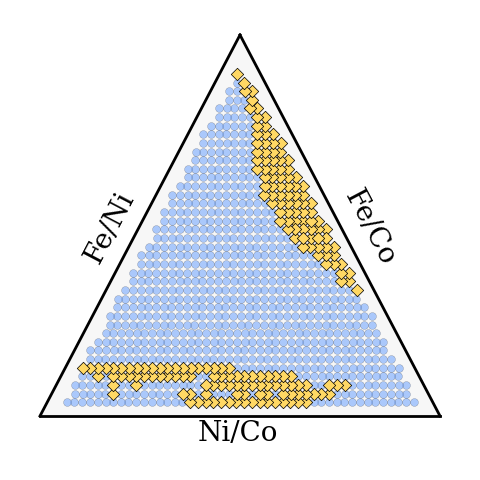

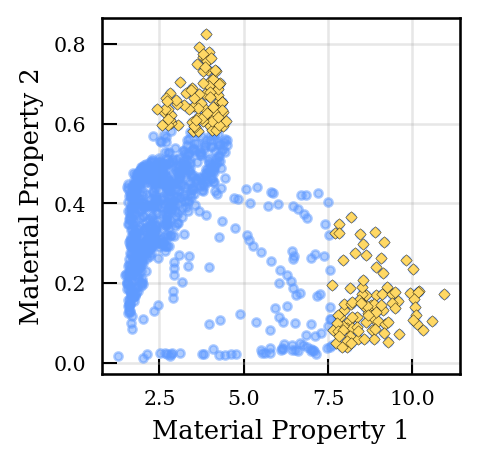

In [13]:
from src.plotting import plot_algo_true_function

plot_algo_true_function(algorithm, x_scaler, y_scaler, X_norm, Y_norm, posterior_mean=None, posterior_samples=None)

The goal of our design of experiments procedure is to find the subset above, without having to fully enumerate all experiments (as above). In this repo, we present a number of different useful algorithms for searching chemical spaces; please look in <code>src/algorithms.py</code>.

## Running an algorithm on the posterior mean or posterior samples from a Gaussian Process

The catch in the analysis above is that of course we do not actually know f(X). We only know X -- the set of materials we can make. f(X) is expensive and time-consuming to obtain. The question is, can we perform experiments in an intelligent way to approximate the result of running the algorithm on the true function without having to do the full set of experiments. 

The answer is yes, using the technique of Bayesian Algorithm Execution. The idea is to train a Gaussian Process model to approximate f(X) using small datasets. The algorithm can be executed on the predicted f(X) rather than on the true f(X) cheaply. We can then use the information from the algorithm output to guide decision making.

Let's see how to do this. First we start with a small dataset consisting of a small subset of X and f(X):

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.975, random_state=42)
X_train.shape, y_train.shape

((23, 2), (23, 2))

We define a Gaussian Process model and fit it to the data. A Gaussian Process is a distribution over functions; we can obtain a posterior mean function $\bar{f}$ or sample from it to generate posterior function samples, $f_{i:n}$. Note, we use a custom class MGPR which is a simple wrapper on the sklearn GaussianProcessRegressor in order to have multiple independent GPs (one for each of $m$ measured properties). 

In [15]:
from src.models import MGPR

kernel_initial = ConstantKernel(constant_value=1.0, constant_value_bounds=[0.01, 3.0]) * Matern(nu = 5/2, length_scale= n_features * [1.0], length_scale_bounds= n_features * [[0.01, 3.0]]) + WhiteKernel(noise_level=0.01, noise_level_bounds='fixed')
kernel_initial_list = n_properties * [kernel_initial]

multi_gpr = MGPR(kernel_list=kernel_initial_list)

multi_gpr.fit(X_train, y_train)

Now that we have fitted the GP model, we can use it to predict a mean response (posterior_mean) and a predicted uncertainty (posterior_std) across the entire design space. 

In [16]:
posterior_mean, posterior_std = multi_gpr.predict(X_norm)

Now, finally, we can execute our algorithm on the posterior_mean instead of f(X). This will give us a set of points predicted (based on the posterior mean) to be the target design points. These points are shown in maroon below. Note, even with relatively limited data, there is substantial overlap between the predicted and true target points. Executing an algorithm on the posterior mean is a core idea of the MeanBAX algorithm (tutorial 3). 

<code>algorithm.identify_subspace(f_x = $\bar{f}$, x = X)</code>


predicted X: , [91.7  3.6], [89.7  3.6], [87.8  3.6], [85.9  3.6], [84.   3.6], [82.   3.6], [80.1  3.6], [78.2  3.6], [76.2  3.6], [43.5 44.4], [59.6 35.4], [57.6 35.4], [55.7 35.4], [53.8 35.4], [51.9 35.4], [49.9 35.4], [38.2 51.2], [58.4 37.6], [56.5 37.6], [54.6 37.6], [52.7 37.6], [50.7 37.6], [48.8 37.6], [46.9 37.6], [55.4 39.9], [53.5 39.9], [51.5 39.9], [49.6 39.9], [47.7 39.9], [45.8 39.9], [52.3 42.2], [50.4 42.2], [48.5 42.2], [46.6 42.2], [44.6 42.2], [84.4 10.4], [82.5 10.4], [80.6 10.4], [78.7 10.4], [76.7 10.4], [74.8 10.4], [72.9 10.4], [71.  10.4], [69.  10.4], [67.1 10.4], [65.2 10.4], [63.2 10.4], [61.3 10.4], [59.4 10.4], [57.5 10.4], [55.5 10.4], [53.6 10.4], [51.7 10.4], [49.7 10.4], [47.8 10.4], [45.9 10.4], [44.  10.4], [42.  10.4], [40.1 10.4], [38.2 10.4], [36.3 10.4], [34.3 10.4], [32.4 10.4], [30.5 10.4], [28.5 10.4], [26.6 10.4], [24.7 10.4], [22.8 10.4], [20.8 10.4], [18.9 10.4], [17.  10.4], [15.  10.4], [13.1 10.4], [11.2 10.4], [ 9.3 10.4], [ 7.3 10.4

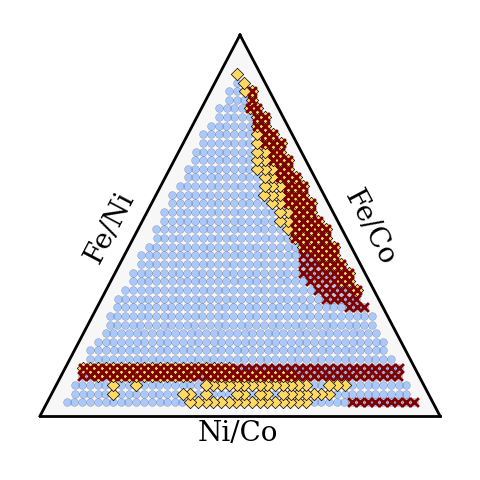

In [17]:
algorithm = PercentileIntersection2D(user_algo_params=user_algo_params)
posterior_mean_subset_ids = algorithm.identify_subspace(f_x = posterior_mean, x = X_norm)
print("predicted X: ", *X[posterior_mean_subset_ids], sep=', ')

plot_algo_true_function(algorithm, x_scaler, y_scaler, X_norm, Y_norm, posterior_mean=posterior_mean, posterior_samples=None)

In addition to the posterior mean, we can also draw posterior samples from the GP model. Each posterior sample represents a guess over the entire domain of the values of the properties. Again, we can run our algorithm on posterior samples to get predicted target locations. In the example below, we draw 20 functions from the posterior distribution of the GP and execute our algorithm.

<code>algorithm.identify_subspace(f_x = $f_i$, x = X)</code>


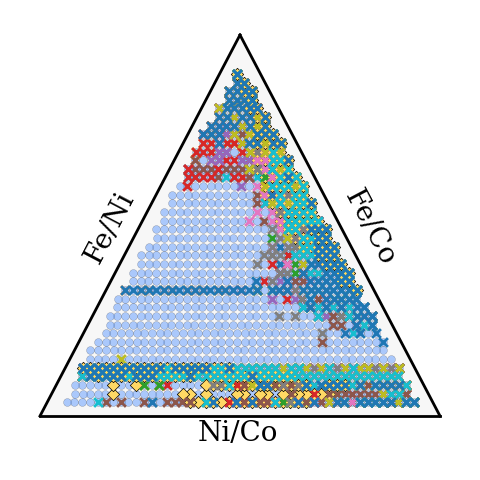

In [18]:
posterior_samples = multi_gpr.sample_y(X_norm, n_samples = 20)
plot_algo_true_function(algorithm, x_scaler, y_scaler, X_norm, Y_norm, posterior_mean=None, posterior_samples=posterior_samples)

Executing an algorithm on the posterior samples is a core idea of the InfoBAX algorithm. In [tutorial 2](tutorial_2_defining_metrics.ipynb), we will see how to quantify metrics for data acquisition quality. In [tutorial_3](tutorial_3_data_acquisition_using_BAX.ipynb), we will see how the information of algorithm execution on ML fitting models is converted in an acquisition function for efficient sampling. 
